#### Import the package and read the data

In [1]:
#Import the package
import torch
import torch.optim as optim
import torch.utils.data as Data
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import numpy as np

from network import DeepSeparator
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

#read data
data_mat_dict = loadmat('./data/data.mat')
simulated_impulse = data_mat_dict['simulated_impulse']
simulated_noises = data_mat_dict['simulated_impulse_noise']

#### Define the Z-score normalization function, and standard the input signal 

In [2]:
def standardization(data):
    '''z-score normalization
    '''
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma,  mu, sigma

#### Define model parameters, models, and loss functions

In [3]:
BATCH_SIZE = 1000
learning_rate = 1e-4
epochs = 1000

mini_loss = 1

print_loss_frequency = 1
print_train_accuracy_frequency = 1
test_frequency = 1

model_name = 'simulated_impulse'
model = DeepSeparator()
loss = nn.MSELoss(reduction='mean')

#### Standardizes the data and extracts the training set and testing sets

In [4]:
noise_train, noise_test, label_train, label_test = train_test_split(simulated_noises, simulated_impulse, test_size=0.1,shuffle=True)
temp_data = np.concatenate((noise_train, label_train),axis=0)
train_data, mu, sigma = standardization(temp_data)
train_label = (np.concatenate((label_train,label_train),axis=0) - mu) / sigma
train_indicator = np.zeros(train_data.shape[0])

test_data = (noise_test - mu) / sigma
test_label = (label_test - mu) / sigma
test_indicator = np.zeros(test_data.shape[0])

train_torch_dataset = Data.TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_indicator).unsqueeze(1), torch.from_numpy(train_label))
test_torch_dataset  = Data.TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_indicator).unsqueeze(1), torch.from_numpy(test_label))


train_loader = Data.DataLoader(
    dataset=train_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = Data.DataLoader(
    dataset=test_torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

#### The train process

In [5]:
train_loss_list = []
test_loss_list = []

In [6]:
print("torch.cuda.is_available() = ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
if os.path.exists('checkpoint/' + model_name + '.pkl'):
    print('load model')
    model.load_state_dict(torch.load('checkpoint/' + model_name + '.pkl'))


for epoch in range(epochs):

    train_acc = 0
    train_loss = 0

    total_train_loss_per_epoch = 0
    average_train_loss_per_epoch = 0
    train_step_num = 0

    for step, (train_input, indicator, train_output) in enumerate(train_loader):

        train_step_num += 1

        indicator = indicator.float().to(device)
        train_input = train_input.float().to(device)
        train_output = train_output.float().to(device)

        optimizer.zero_grad()

        train_preds = model(train_input, indicator)

        train_loss = loss(train_preds, train_output)

        total_train_loss_per_epoch += train_loss.item()

        train_loss.backward()
        optimizer.step()

    average_train_loss_per_epoch = total_train_loss_per_epoch / train_step_num
    train_loss_list.append(average_train_loss_per_epoch)
    if epoch % print_loss_frequency == 0:
        print('train loss: ', average_train_loss_per_epoch)

    test_step_num = 0
    total_test_loss_per_epoch = 0
    average_test_loss_per_epoch = 0

    if epoch % test_frequency == 0:

        for step, (test_input, test_indicator, test_output) in enumerate(test_loader):

            test_step_num += 1

            test_indicator = test_indicator.float().to(device)

            test_input = test_input.float().to(device)
            test_output = test_output.float().to(device)

            test_preds = model(test_input, test_indicator)

            test_loss = loss(test_preds, test_output)

            total_test_loss_per_epoch += test_loss.item()

        average_test_loss_per_epoch = total_test_loss_per_epoch / test_step_num
        test_loss_list.append(average_test_loss_per_epoch)
        print('--------------test loss: ', average_test_loss_per_epoch)

        if average_test_loss_per_epoch < mini_loss:
            print('save model')
            torch.save(model.state_dict(), 'checkpoint/' + model_name + '.pkl')
            
            mini_loss = average_test_loss_per_epoch
mu_sigma_dict = {'mu':mu,
                'sigma':sigma}
torch.save(mu_sigma_dict ,'checkpoint/' + model_name + '_mu_sigma.pkl')

torch.cuda.is_available() =  True
load model
train loss:  0.04081971012055874
--------------test loss:  0.06972233206033707
save model
train loss:  0.03582733869552612
--------------test loss:  0.06134674698114395
save model
train loss:  0.032351224372784294
--------------test loss:  0.05769587308168411
save model
train loss:  0.03096832086642583
--------------test loss:  0.05501915141940117
save model
train loss:  0.029920664926369984
--------------test loss:  0.05299966409802437
save model
train loss:  0.028445071230332058
--------------test loss:  0.051268529146909714
save model
train loss:  0.027547300172348816
--------------test loss:  0.049780089408159256
save model
train loss:  0.026429777964949608
--------------test loss:  0.04848920553922653
save model
train loss:  0.0254916421448191
--------------test loss:  0.04739765822887421
save model
train loss:  0.02485043245057265
--------------test loss:  0.046294793486595154
save model
train loss:  0.02446847502142191
--------------t

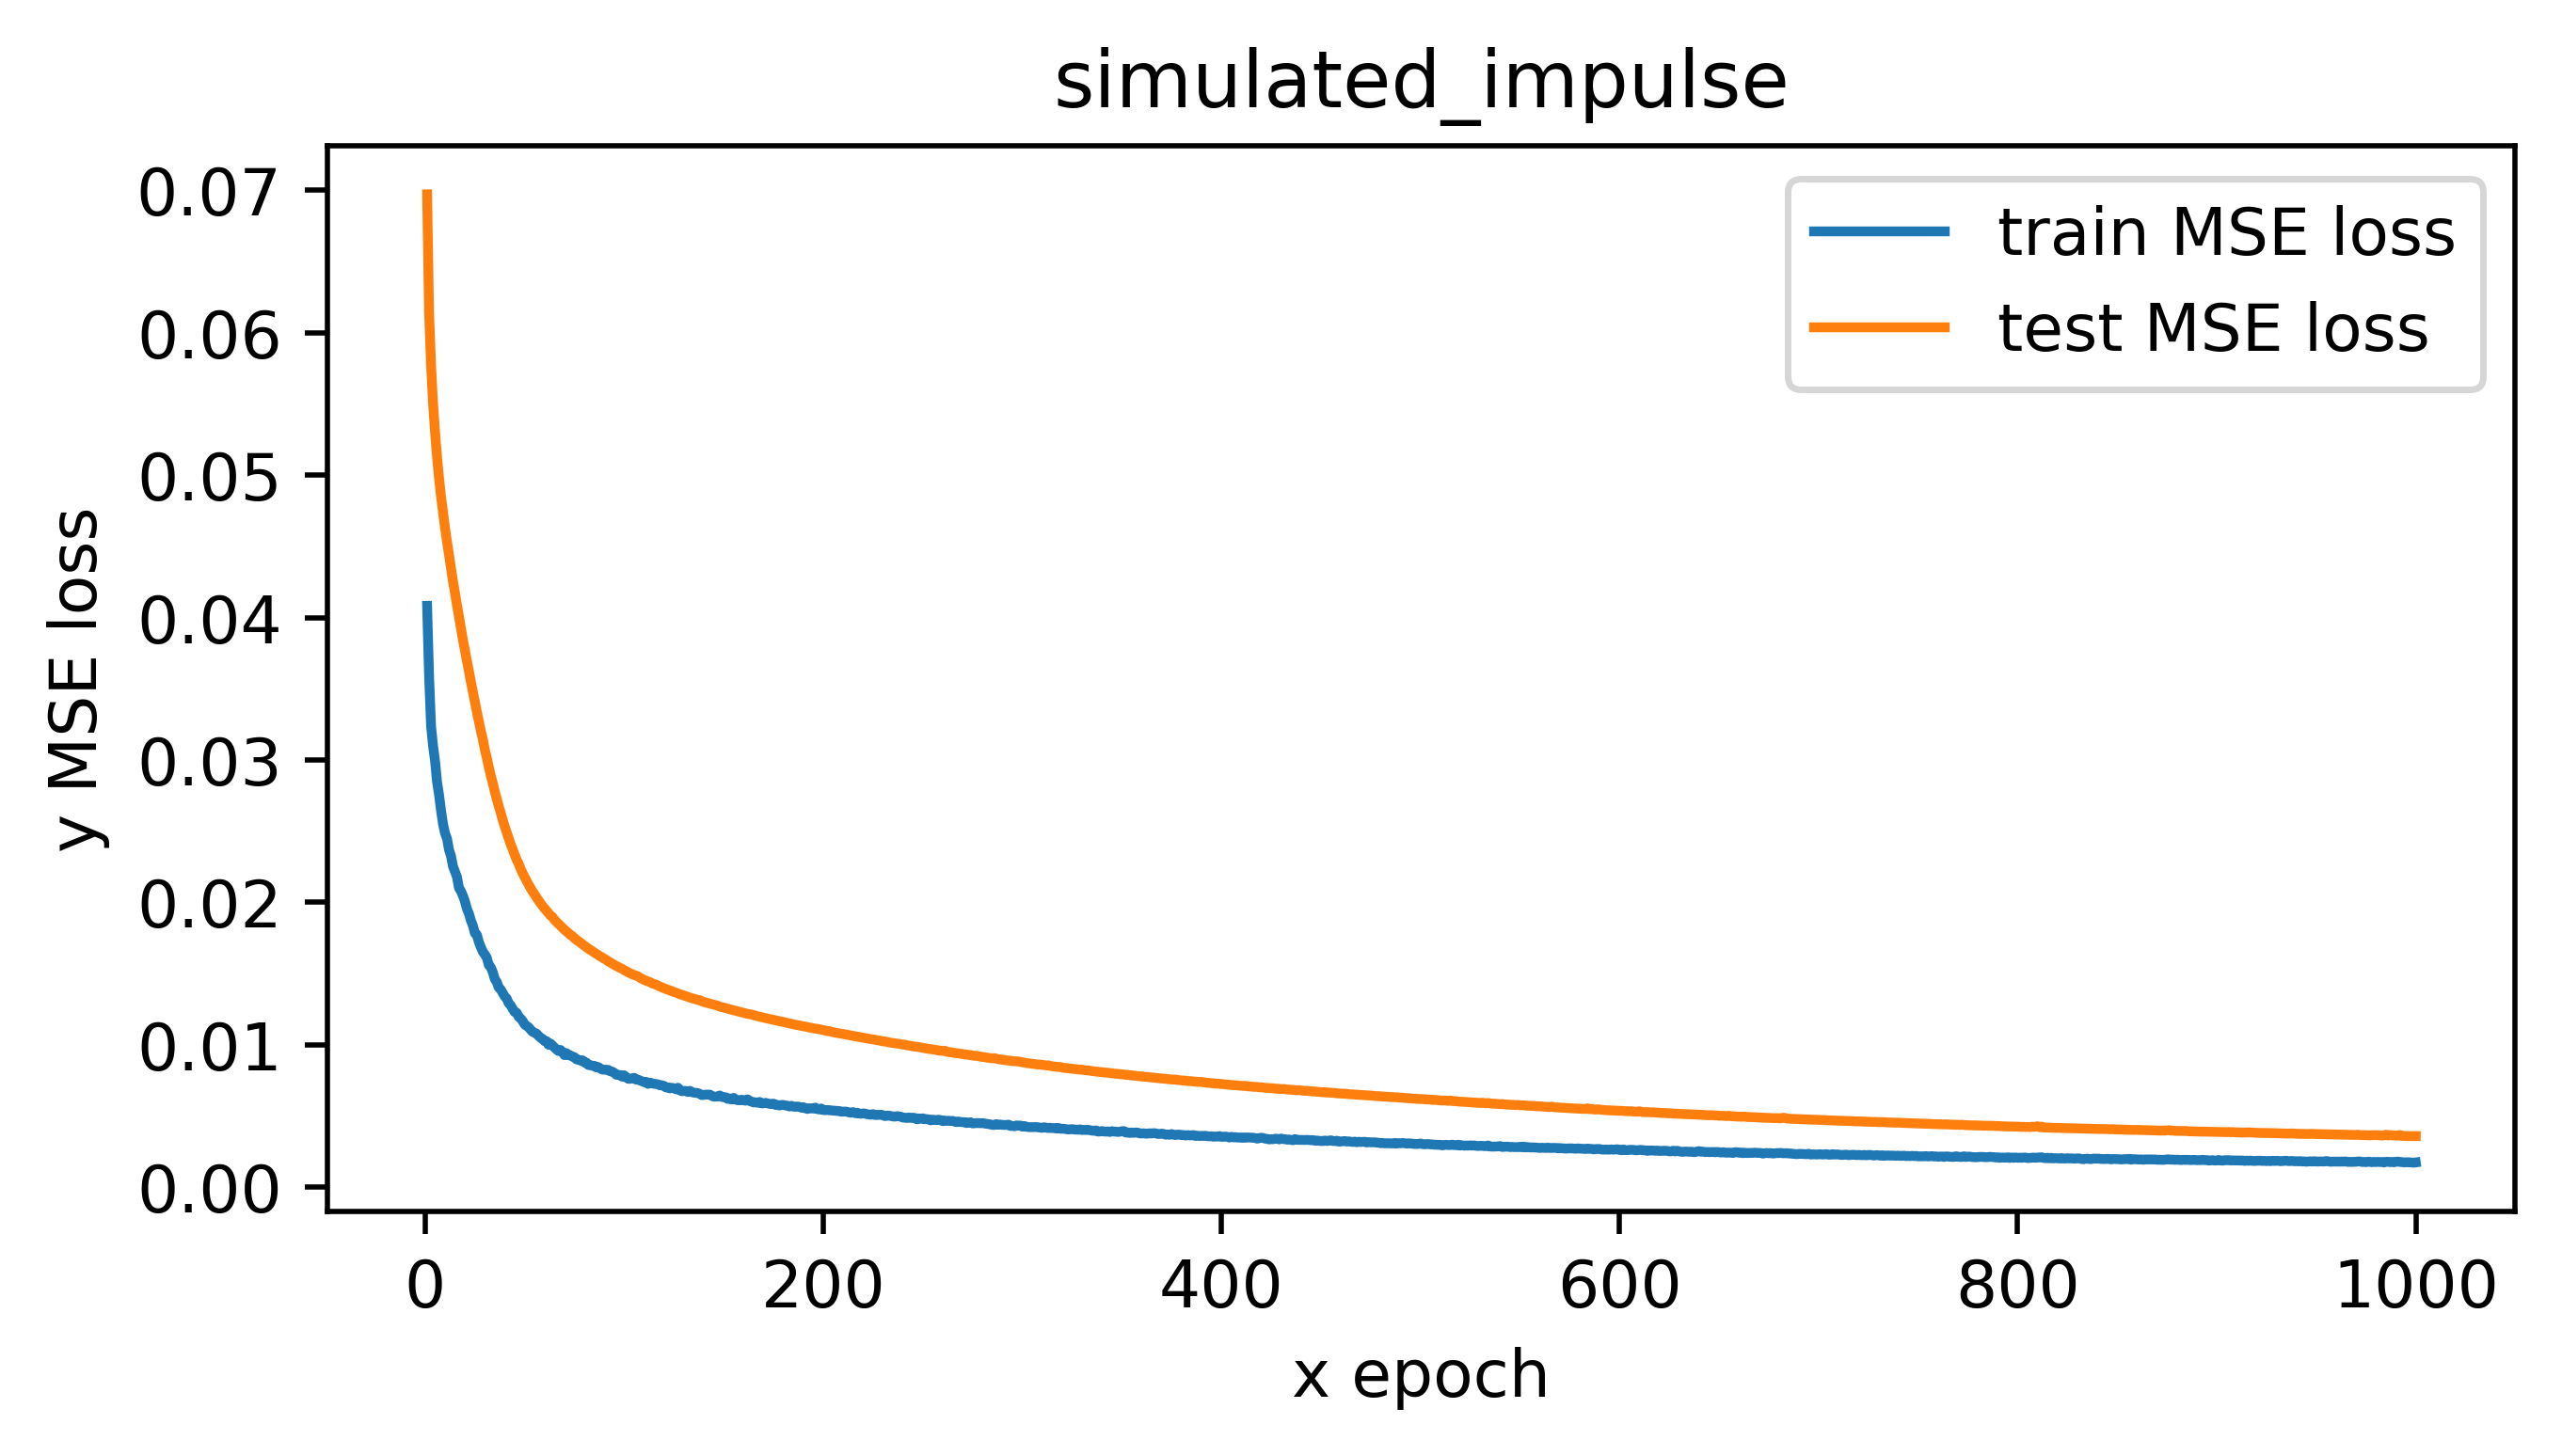

In [7]:
x = np.linspace(1, len(train_loss_list), len(train_loss_list))
y_1 = np.array(train_loss_list)
y_2 = np.array(test_loss_list)
plt.figure(figsize=(6, 3), facecolor='white',dpi=500)
plt.plot(x, y_1,label='train MSE loss')
plt.plot(x, y_2,label='test MSE loss')
plt.legend()
plt.xlabel('x epoch')
plt.ylabel('y MSE loss')
plt.title(model_name)
plt.savefig(model_name+'_loss.png',dpi=500)
plt.show()

In [8]:
# choose one sample for visualization
print("torch.cuda.is_available() = ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DeepSeparator()
model.to(device)  # 移动模型到cuda
if os.path.exists('checkpoint/' + model_name + '.pkl'):
    print('load model')
    model.load_state_dict(torch.load('checkpoint/' + model_name + '.pkl'))

if os.path.exists('checkpoint/' + model_name + '_mu_sigma.pkl'):
    print('load mu and sigma')
    mu_new = torch.load('checkpoint/' + model_name + '_mu_sigma.pkl')['mu']
    sigma_new = torch.load('checkpoint/' + model_name + '_mu_sigma.pkl')['sigma']

torch.cuda.is_available() =  True
load model
load mu and sigma


In [9]:
for (test_input, test_indicator, test_output) in test_loader:
    test_input = test_input.float().to(device)
    test_indicator = test_indicator.float().to(device)
    extracted_signal = model(test_input, test_indicator)

    test_input_value = test_input.cpu()
    test_input_value = test_input_value.detach()
    

    test_output_value = test_output.cpu()
    test_output_value = test_output_value.detach()
    

    extracted_signal_value = extracted_signal.cpu()
    extracted_signal_value = extracted_signal_value.detach()
    max_index = torch.argmax(torch.sum(torch.pow(test_output_value-extracted_signal_value,2),dim=1))
    min_index = torch.argmin(torch.sum(torch.pow(test_output_value-extracted_signal_value,2),dim=1))

    best_input = test_input_value[min_index].numpy()
    best_label = test_output_value[min_index].numpy()
    best_output = extracted_signal_value[min_index].numpy()

    worst_input = test_input_value[max_index].numpy()
    worst_label = test_output_value[max_index].numpy()
    worst_output = extracted_signal_value[max_index].numpy()

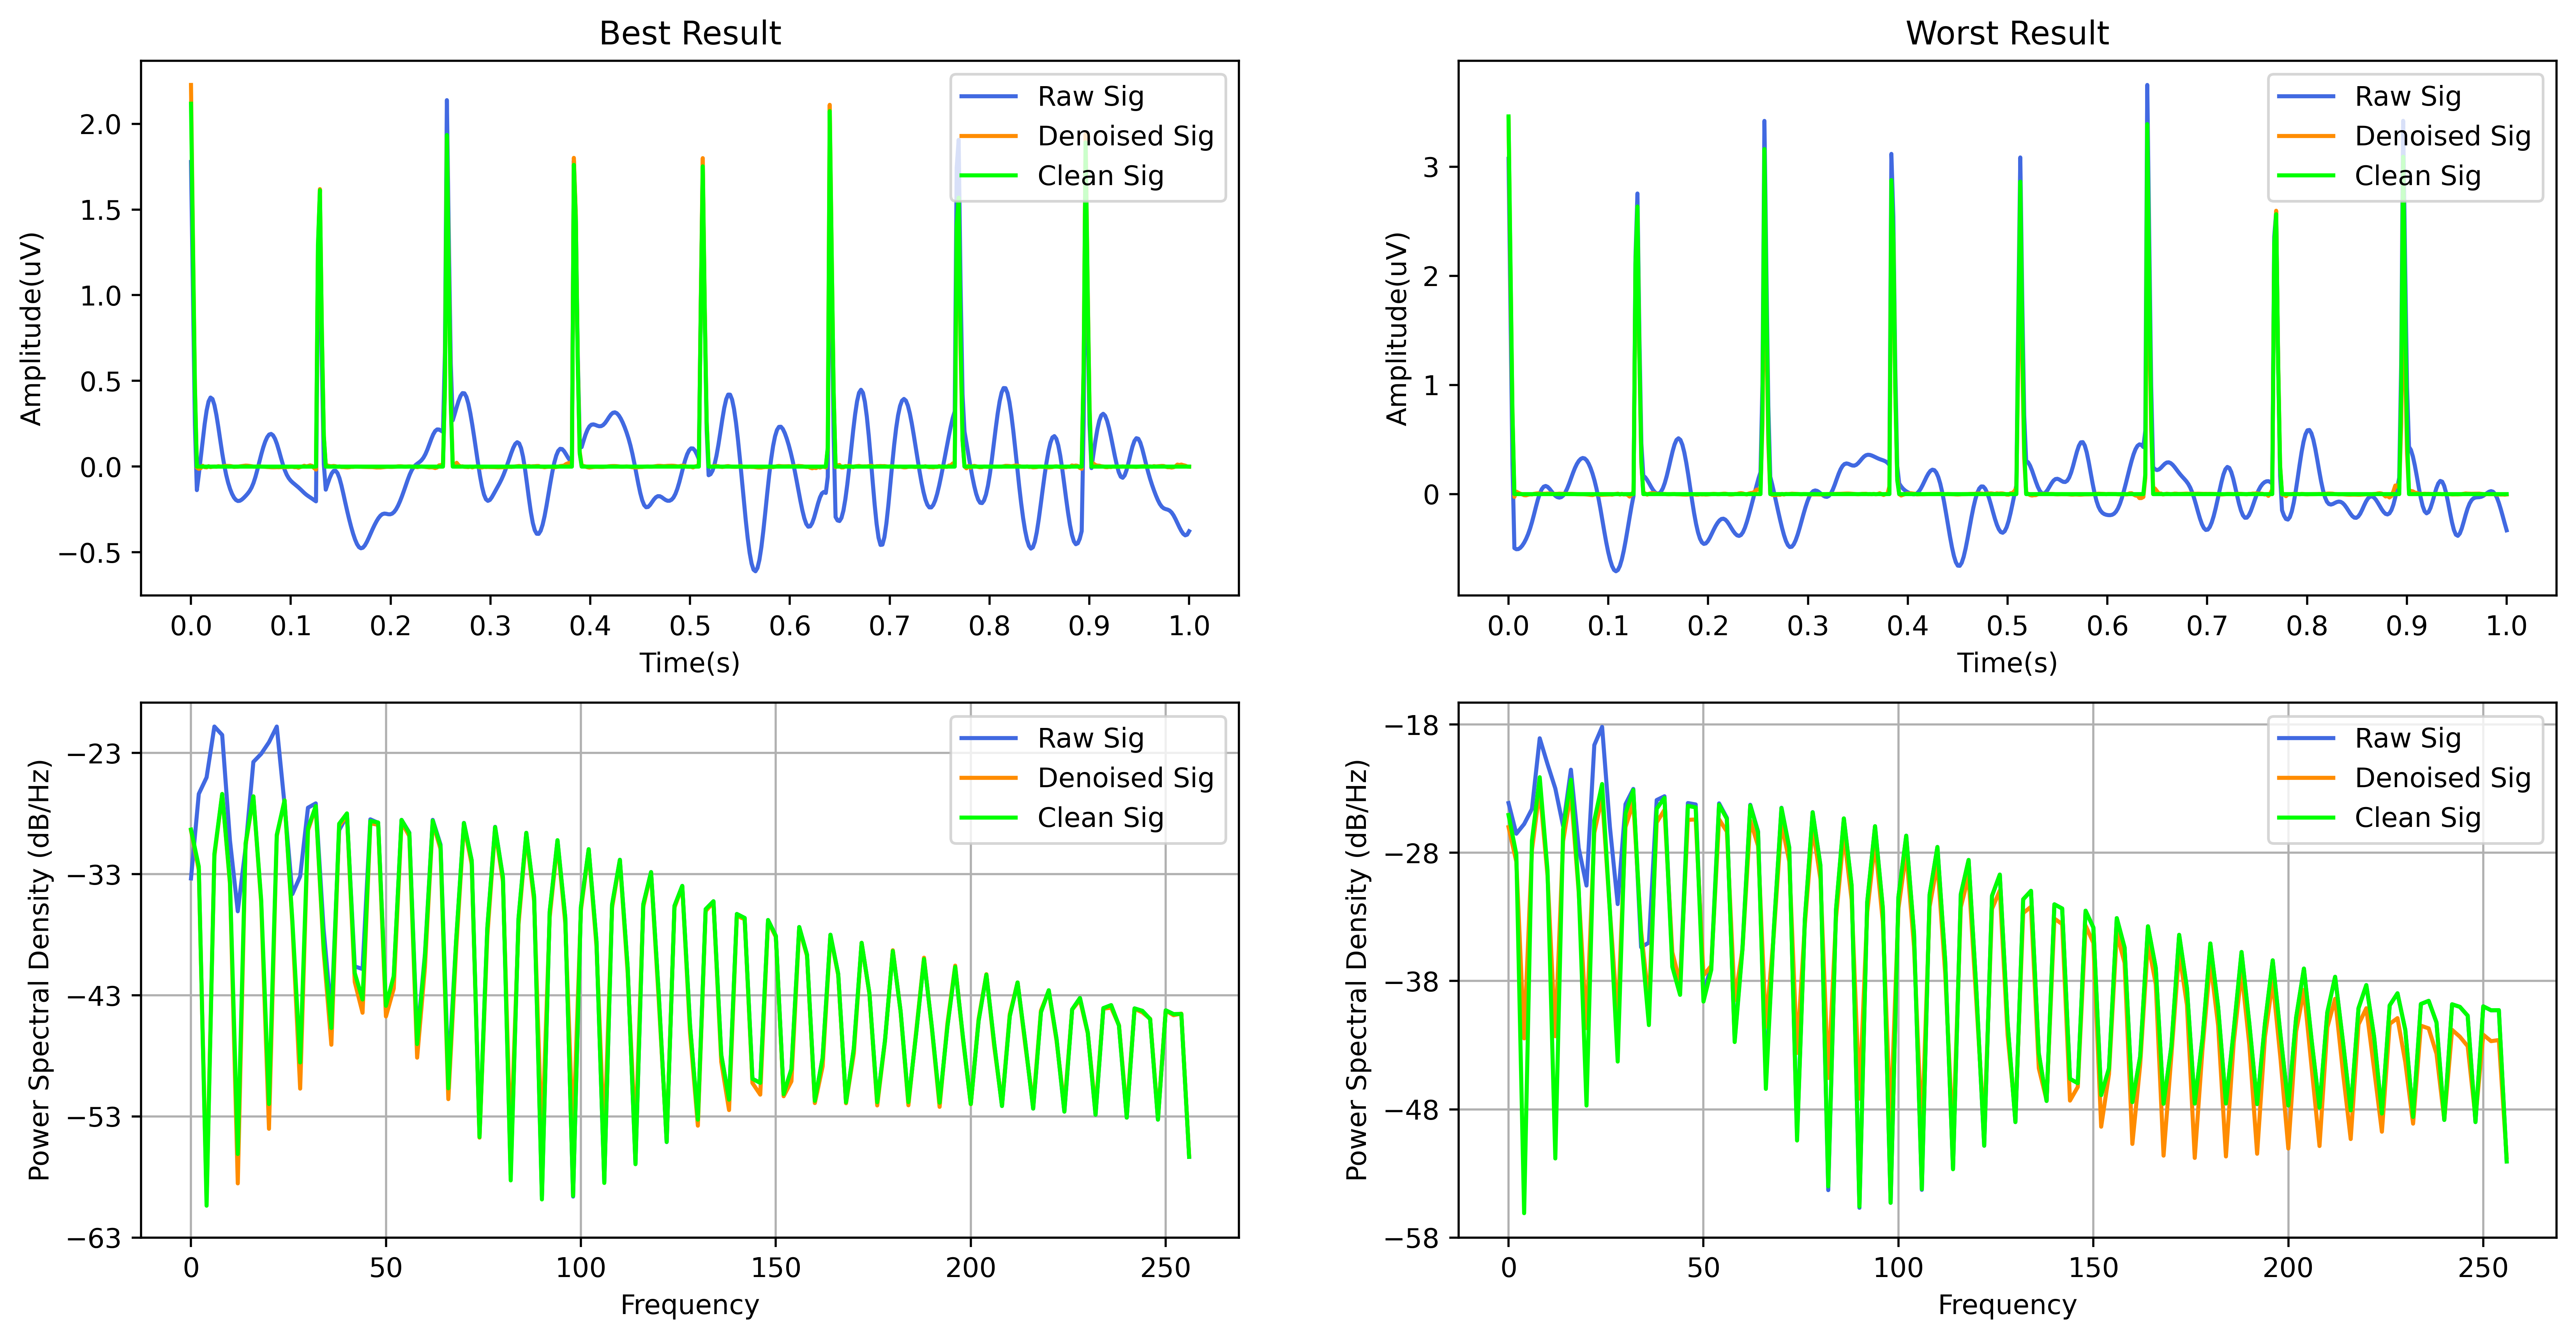

In [10]:
fig = plt.figure(figsize=(16,8), facecolor='white',dpi = 500)
ax = fig.add_subplot(2, 2, 1)

x1 = np.linspace(0,1,512)
y1 = best_input * sigma_new + mu_new
y2 = best_output * sigma_new + mu_new
y3 = best_label * sigma_new + mu_new

ax.plot(x1, y1,color = 'royalblue',label="Raw Sig")
ax.plot(x1, y2,color = 'darkorange',label="Denoised Sig")  
ax.plot(x1, y3,color = 'lime',label="Clean Sig")  
x_interval = [(0.1 * i) for i in range(0, 10)]
x_interval.append(1)
x_interval.sort()
ax.set_xticks(x_interval)
ax.legend(loc = 'upper right')
ax.set_xlabel('Time(s)')
ax.set_ylabel("Amplitude(uV)")
ax.set_title('Best Result')

ax2 = fig.add_subplot(2, 2, 2)
x2 = np.linspace(0,1,512)
w1 = worst_input * sigma_new + mu_new
w2 = worst_output * sigma_new + mu_new
w3 = worst_label * sigma_new + mu_new
ax2.plot(x2, w1,color = 'royalblue',label="Raw Sig")
ax2.plot(x2, w2,color = 'darkorange',label="Denoised Sig")  
ax2.plot(x2, w3,color = 'lime',label="Clean Sig")
x_interval = [(0.1 * i) for i in range(0, 10)]
x_interval.append(1)
x_interval.sort()
ax2.set_xticks(x_interval)
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel("Amplitude(uV)")
ax2.set_title('Worst Result')

ax3 = fig.add_subplot(2, 2, 3)
ax3.psd(y1, Fs = 512,color = 'royalblue',label="Raw Sig")
ax3.psd(y2, Fs = 512,color = 'darkorange',label="Denoised Sig")
ax3.psd(y3, Fs = 512,color = 'lime',label="Clean Sig")
ax3.legend(loc = 'upper right')

ax4 = fig.add_subplot(2, 2, 4)
ax4.psd(w1, Fs = 512,color = 'royalblue',label="Raw Sig")
ax4.psd(w2, Fs = 512,color = 'darkorange',label="Denoised Sig")
ax4.psd(w3, Fs = 512,color = 'lime',label="Clean Sig")
ax4.legend(loc = 'upper right')
plt.savefig(model_name+'_result.png',dpi=500)
plt.show()

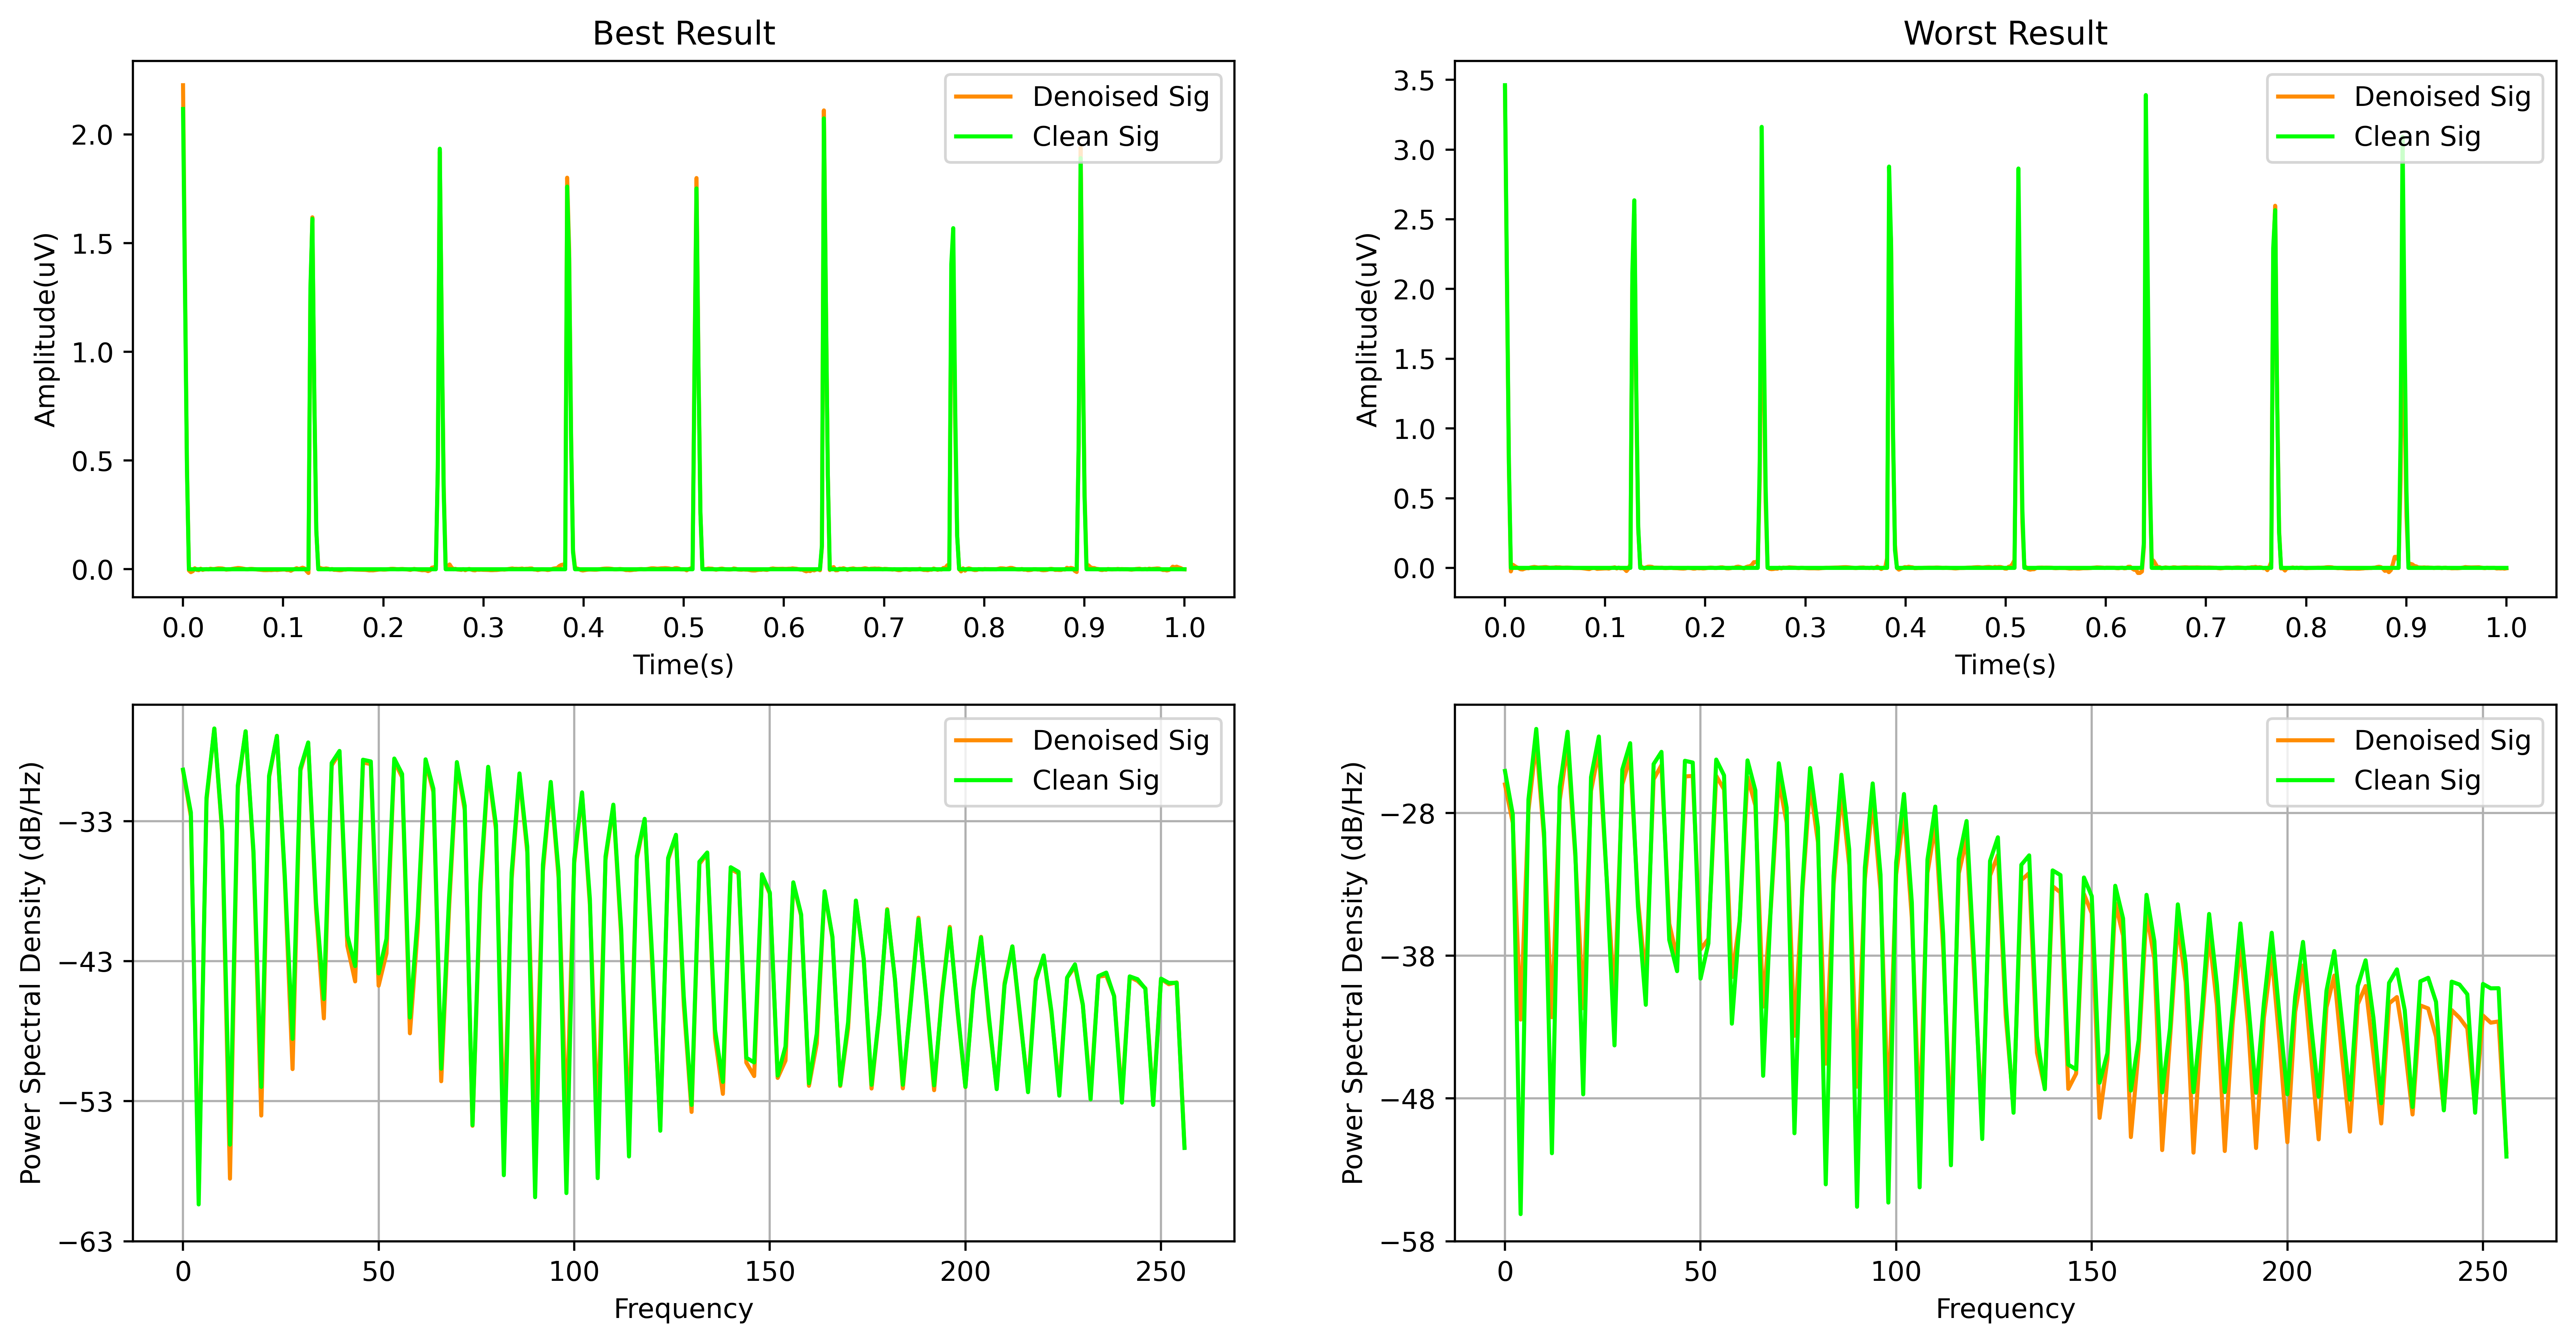

In [11]:
fig = plt.figure(figsize=(16,8), facecolor='white',dpi = 500)
ax = fig.add_subplot(2, 2, 1)

x1 = np.linspace(0,1,512)
y1 = best_input * sigma_new + mu_new
y2 = best_output * sigma_new + mu_new
y3 = best_label * sigma_new + mu_new

ax.plot(x1, y2,color = 'darkorange',label="Denoised Sig")  
ax.plot(x1, y3,color = 'lime',label="Clean Sig")  
x_interval = [(0.1 * i) for i in range(0, 10)]
x_interval.append(1)
x_interval.sort()
ax.set_xticks(x_interval)
ax.legend(loc = 'upper right')
ax.set_xlabel('Time(s)')
ax.set_ylabel("Amplitude(uV)")
ax.set_title('Best Result')

ax2 = fig.add_subplot(2, 2, 2)
x2 = np.linspace(0,1,512)
w1 = worst_input * sigma_new + mu_new
w2 = worst_output * sigma_new + mu_new
w3 = worst_label * sigma_new + mu_new

ax2.plot(x2, w2,color = 'darkorange',label="Denoised Sig")  
ax2.plot(x2, w3,color = 'lime',label="Clean Sig")
x_interval = [(0.1 * i) for i in range(0, 10)]
x_interval.append(1)
x_interval.sort()
ax2.set_xticks(x_interval)
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel("Amplitude(uV)")
ax2.set_title('Worst Result')

ax3 = fig.add_subplot(2, 2, 3)
ax3.psd(y2, Fs = 512,color = 'darkorange',label="Denoised Sig")
ax3.psd(y3, Fs = 512,color = 'lime',label="Clean Sig")
ax3.legend(loc = 'upper right')

ax4 = fig.add_subplot(2, 2, 4)
ax4.psd(w2, Fs = 512,color = 'darkorange',label="Denoised Sig")
ax4.psd(w3, Fs = 512,color = 'lime',label="Clean Sig")
ax4.legend(loc = 'upper right')
plt.savefig(model_name+'_result_2.png',dpi=500)
plt.show()